Install Libraries

In [64]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.style.use('seaborn')

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import math
import pickle

from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRFRegressor
from sklearn.svm import SVR   
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor      
from sklearn.metrics import mean_squared_error, r2_score


import warnings
warnings.filterwarnings('ignore')



Loading the Data

In [2]:
if not os.path.exists('Results'):
      os.mkdir('Results')

In [3]:
df = pd.read_csv('archive/diamonds.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Investigate the data

In [4]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [6]:
#we have no missing values
df.isna().sum()


carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [7]:
# find the categorical and the numerical attributes
cat = list(df.select_dtypes(exclude = 'number'))
num = list(df.select_dtypes(include = 'number'))

In [8]:
df[cat] = df[cat].astype('category')

In [9]:
df.dtypes

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

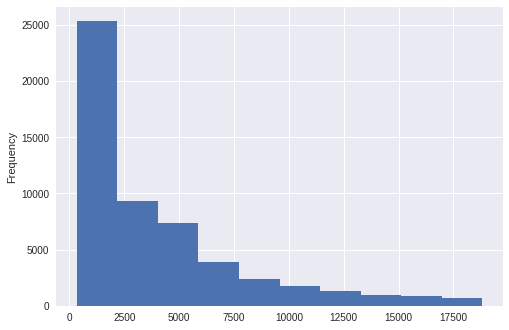

In [10]:
df.price.plot.hist()

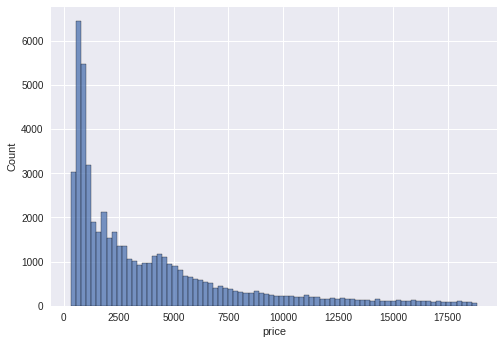

In [11]:
fig , ax = plt.subplots()
ax = sns.histplot(data=df,x = 'price' )

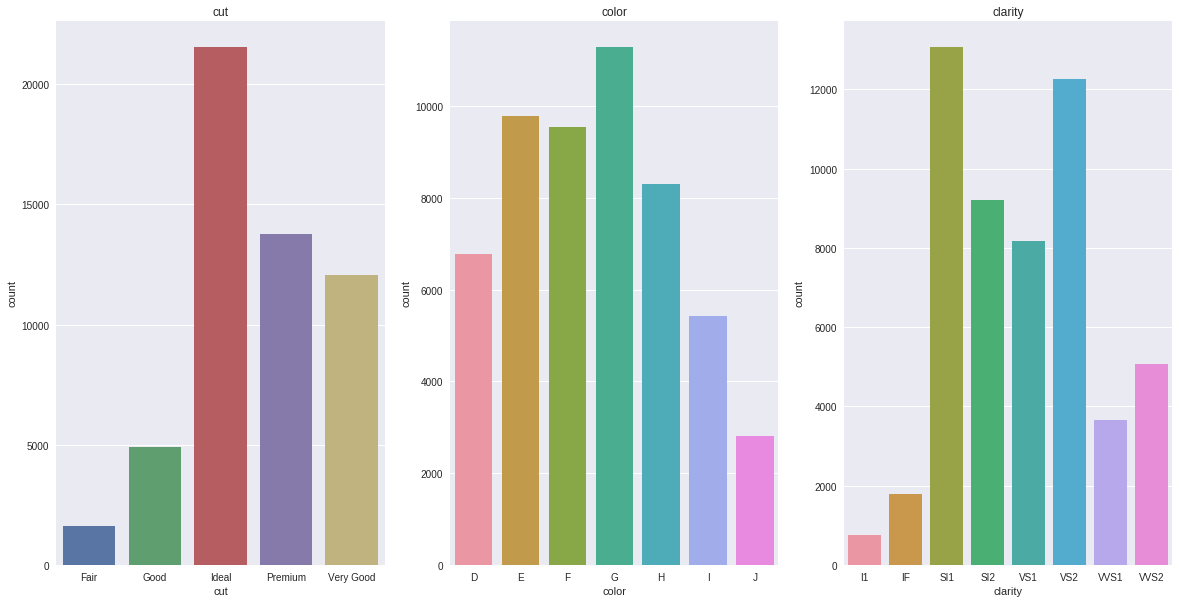

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize =(20,10))
idx = 0
for i in cat:
      sns.countplot(data = df, x = i, ax = ax[idx]).set_title(i)
      idx = idx + 1

In [2]:
# The higher the number counts, the higher the cutting quality (makes sense)

# Some colors are more common than others, with a random distribution.

# Clarity. has a normal distribution, with sonme left skewness.

In [13]:
df['z'].min()

0.0

Depth and its relation with (x,y,z)

In [3]:
#it supposed to calculate depth from equation: depth = 2z/(x+y) is that true.. let's check

#But first let's check the values of x,y,z,depth. They are supposed to be suitable numbers for length measurements.

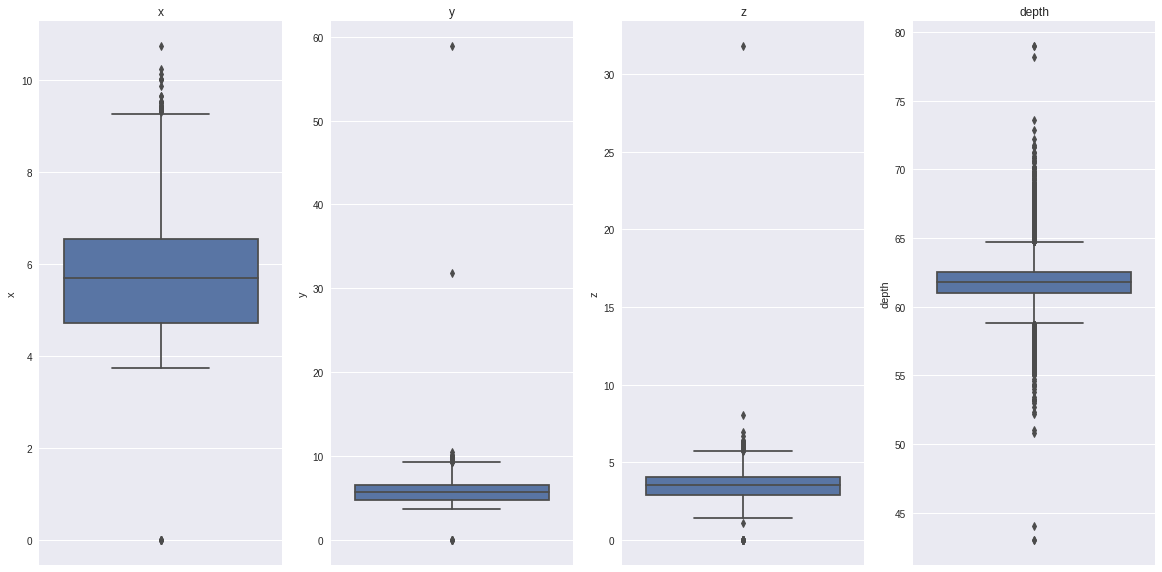

In [14]:
idx = 0
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20,10))
for i in ['x', 'y', 'z', 'depth']:
      sns.boxplot(y = df[i],ax = axes[idx], orient='v').set_title(i)
      idx +=1
plt.show()


In [1]:
# Outliers are normal (maybe they are royal pieces or something rare), but can't let them affect negatively in our model. at least we must remove the very far of them.

# Zeros are not accepted sure.

# Removing zeros first and those who are unmatched depth (different greater than 1)

In [15]:
df['calc_depth'] =round((df.z*2)/(df.x + df.y)*100,1)
df.drop(df[ (df.x == 0 ) | (df.y == 0) | (df.z == 0) | (df.depth == 0) | (df.y > 20) | (df.z > 10) | (df.z < 1.1)].index, inplace = True)
df.drop(df[np.abs(df.depth - df.calc_depth)>1].index, inplace = True)
df.drop('calc_depth', axis = 1, inplace = True)

df

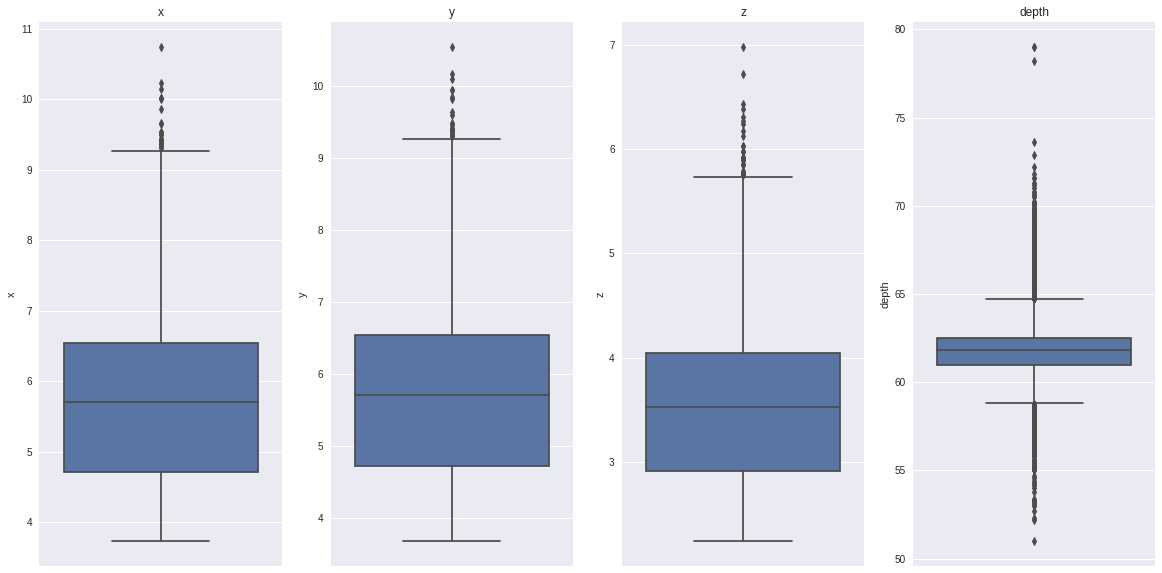

In [16]:
idx = 0
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20,10))
for i in ['x', 'y', 'z', 'depth']:
      sns.boxplot(y = df[i], ax = axes[idx], orient = 'v').set_title(i)
      idx +=1
plt.show()

In [ ]:
# Now measures are more compatible with the depth, we can even remove depth features to avoid any redundancy (not now, at the end of EDA)

In [17]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [ ]:
# What about carat and Table features?


Text(0.5, 1.0, 'table')

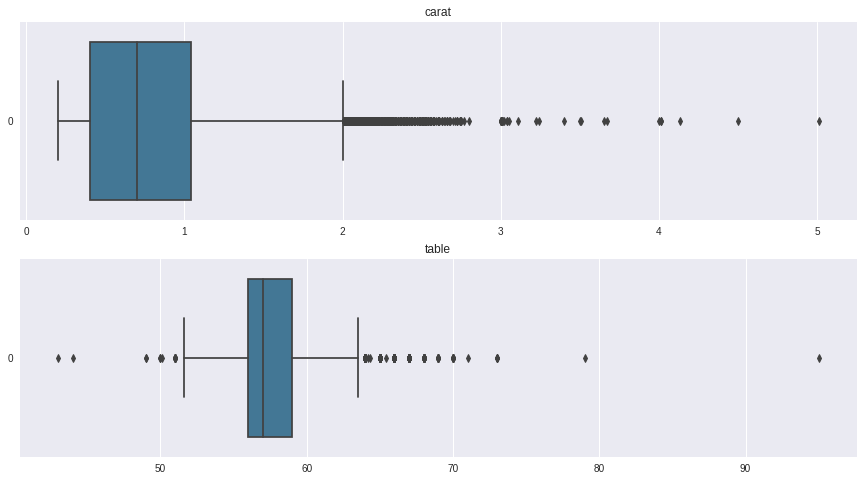

In [18]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15,8))
sns.boxplot(df.carat, ax = ax[0],palette='mako', orient = 'h').set_title('carat')
sns.boxplot(df.table, ax = ax[1], palette= 'mako', orient = 'h').set_title('table')

In [4]:
# Too many outliers in carat and not too many in table. Let's count them.

In [19]:
carat_q1, carat_q3 = df['carat'].quantile(0.25), df['carat'].quantile(0.75)
table_q1, table_q3 = df['table'].quantile(0.25), df['table'].quantile(0.75)


In [20]:
carat_upper = carat_q3 + (carat_q3 - carat_q1)*1.5
carat_lower = carat_q1 - (carat_q3 - carat_q1)*1.5

table_upper = table_q3 + (table_q3 - table_q1)*1.5
table_lower = table_q1 - (table_q3 - table_q1)*1.5


In [21]:
df[(df.carat > carat_upper) | (df.carat < carat_lower)].count()[0]

1880

In [22]:
df[(df.table > table_upper) | (df.table < table_lower)].count()[0]

601

In [23]:
# lets check the price

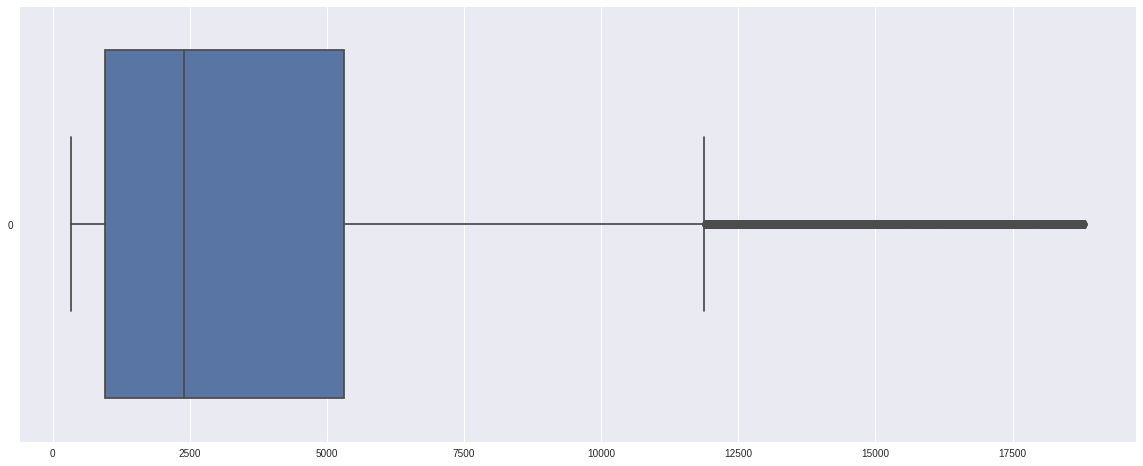

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,8), sharex = False, sharey = False)
sns.boxplot(df.price, orient = 'h');

In [25]:
price_q1, price_q3 = df.price.quantile(0.25), df.price.quantile(0.75)
price_upper = price_q3 + (price_q3 - price_q1)*1.5
price_upper

11876.5

In [26]:
df[df.price >price_upper]

,carat,cut,color,clarity,depth,table,price,x,y,z
23815,1.50,Premium,F,SI1,62.9,59.0,11878,7.34,7.29,4.60
23816,1.50,Very Good,I,VS1,63.3,54.0,11879,7.26,7.33,4.62
23817,1.22,Ideal,F,VVS2,62.7,54.0,11880,6.79,6.84,4.27
23818,1.20,Ideal,E,VVS2,61.5,57.0,11883,6.79,6.89,4.21
23819,1.83,Premium,I,SI1,62.9,55.0,11883,7.90,7.78,4.93
...,...,...,...,...,...,...,...,...,...,...
27745,2.00,Very Good,H,SI1,62.8,57.0,18803,7.95,8.00,5.01
27746,2.07,Ideal,G,SI2,62.5,55.0,18804,8.20,8.13,5.11
27747,1.51,Ideal,G,IF,61.7,55.0,18806,7.37,7.41,4.56
27748,2.00,Very Good,G,SI1,63.5,56.0,18818,7.90,7.97,5.04


Visualizations


In [27]:
num

['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

In [28]:
cat

['cut', 'color', 'clarity']

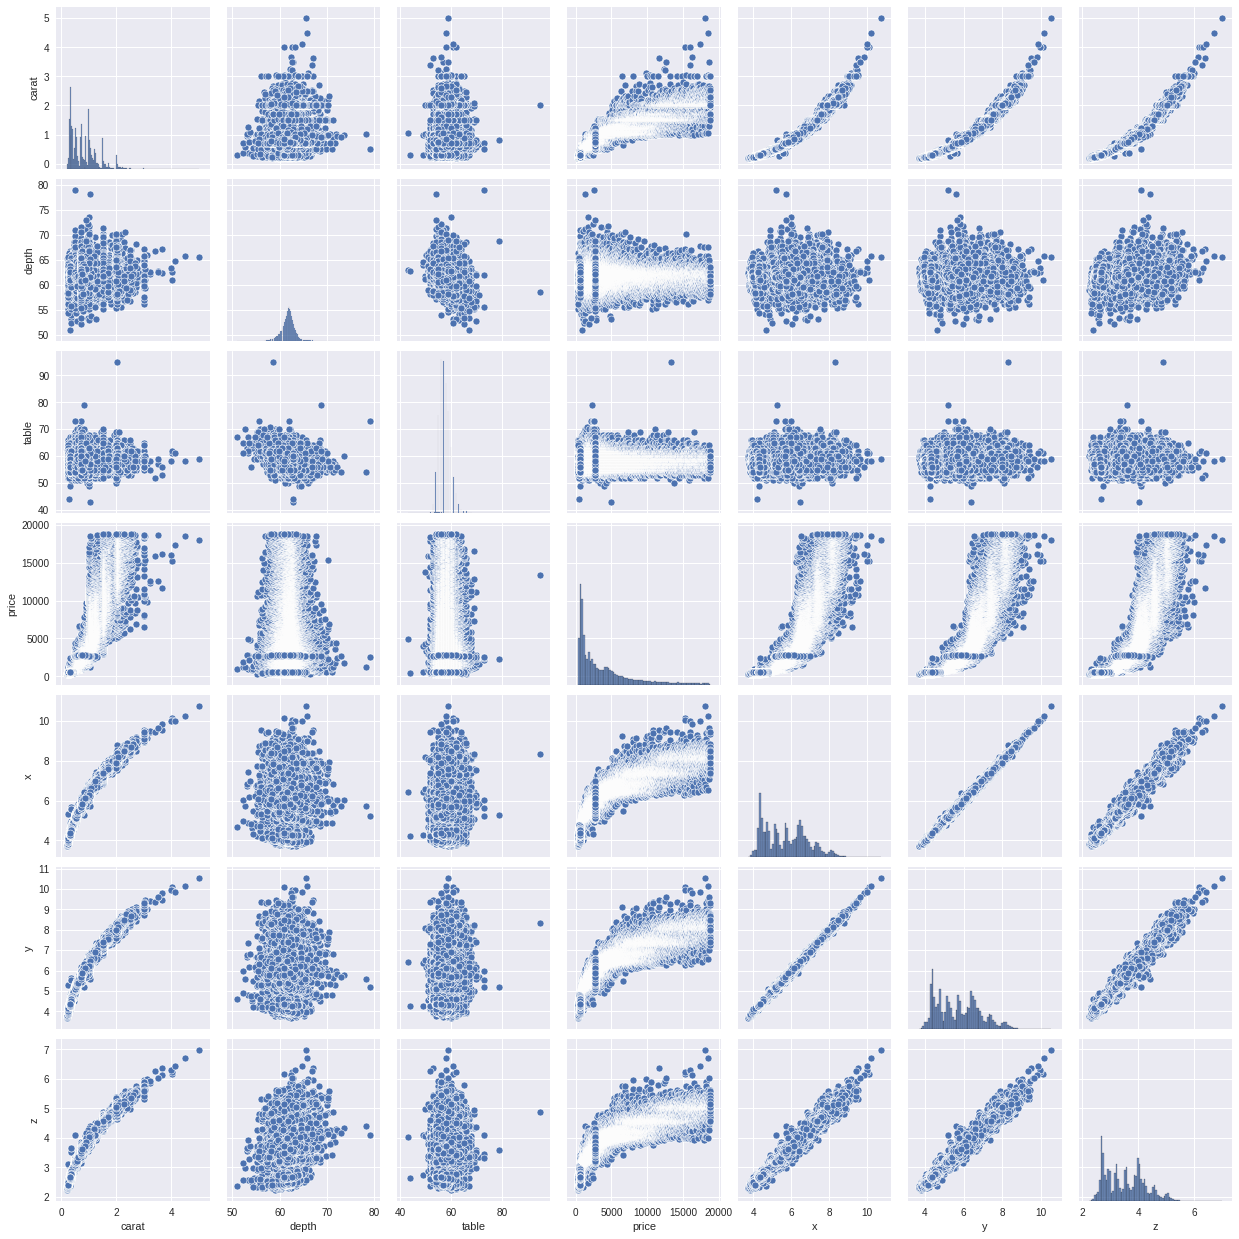

In [29]:
sns.pairplot(data = df[num]);

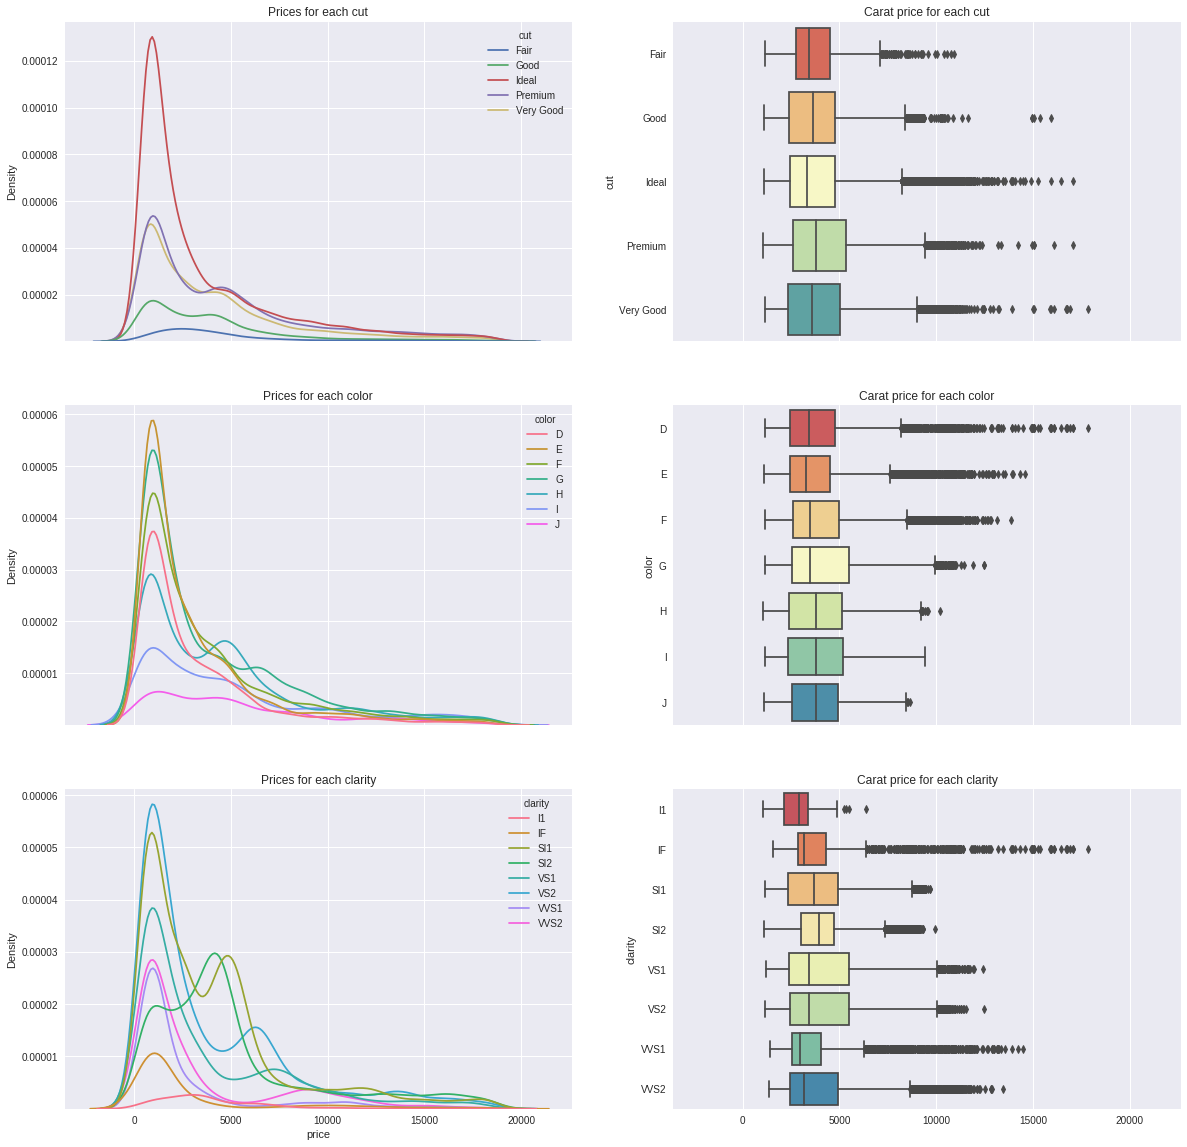

In [30]:
fig, axes = plt.subplots(nrows = len(cat), ncols = 2, figsize = (20,20),sharex = True)
for i in range(len(cat)):
      sns.kdeplot(data = df, x = 'price', hue = cat[i], ax = axes[i][0]).set_title(f'Prices for each {cat[i]}')
      sns.boxplot(data =df, y=cat[i] , x=df['price']/df['carat'], palette='Spectral', ax=axes[i][1]).set_title(f'Carat price for each {cat[i]}')

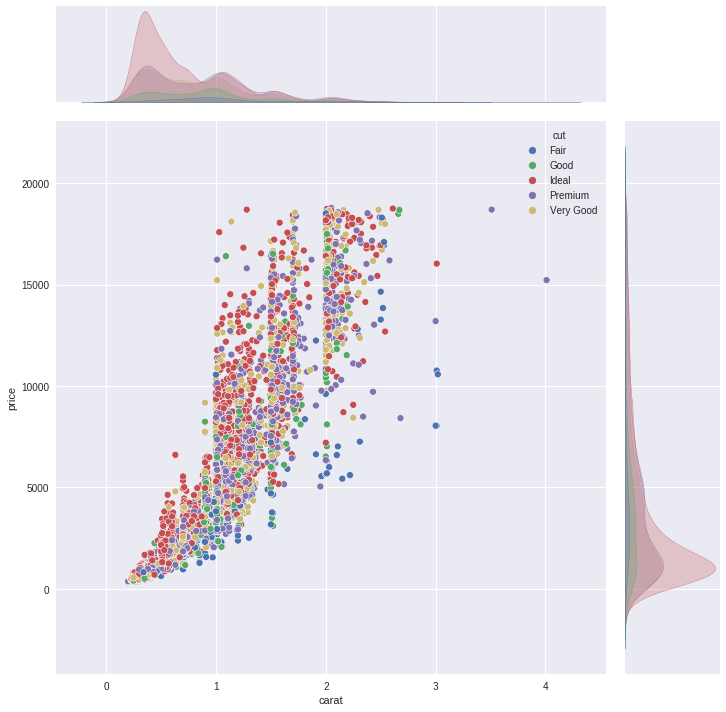

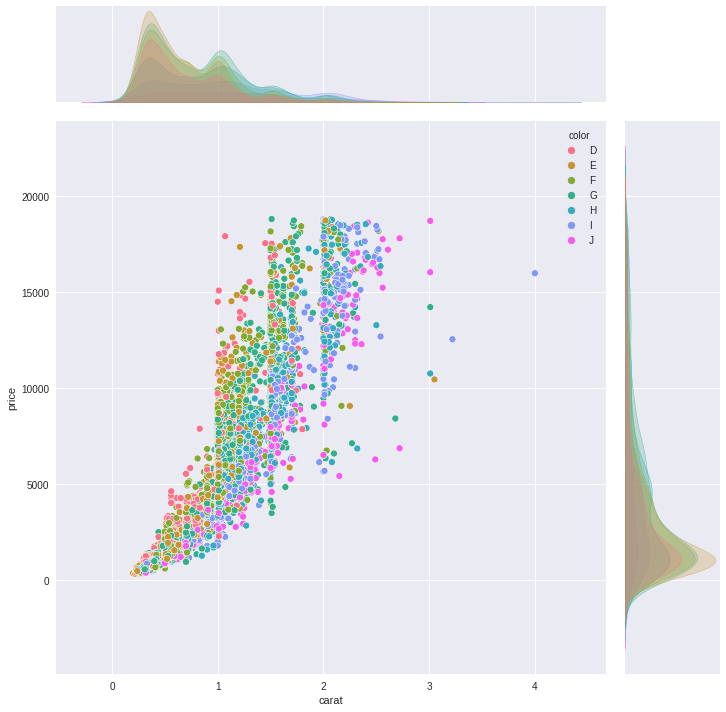

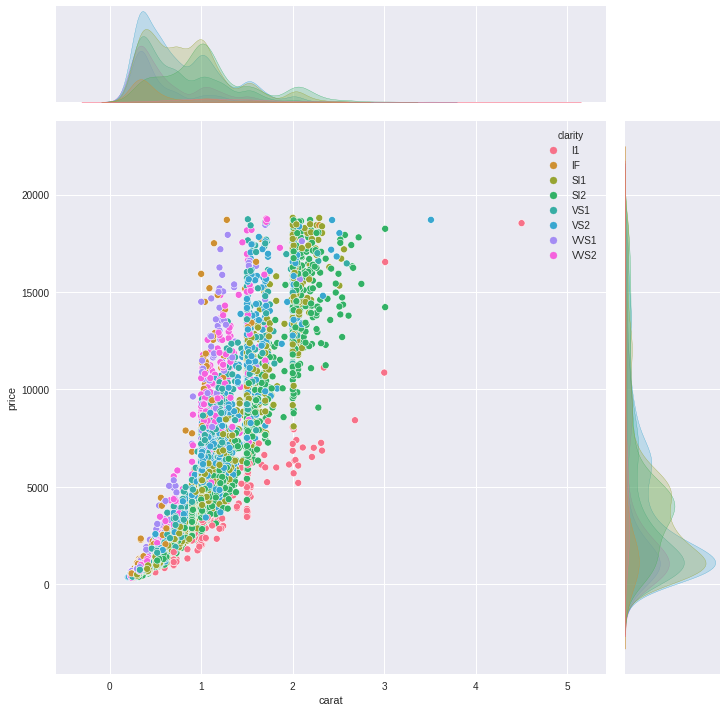

In [31]:
for i in range(len(cat)):
      sns.jointplot(data = df.sample(10000), x = 'carat', y = 'price', hue = cat[i], height = 10)
                                                      

In [32]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


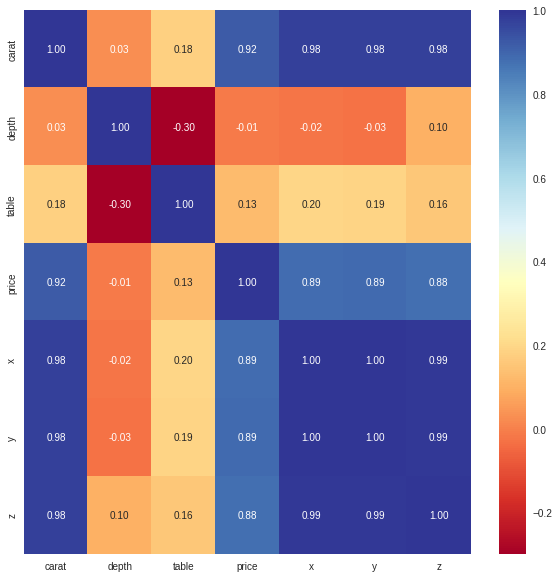

In [33]:
fig , ax = plt.subplots(figsize = (10, 10))
ax = sns.heatmap(df.corr(), annot = True, fmt = '.2f', cmap = 'RdYlBu')

Processing the model

In [34]:
y = df['price']
df.drop('price', axis = 1, inplace = True)

In [35]:
# encoding 

In [36]:
one_hot = OneHotEncoder()
tranformer = ColumnTransformer([('one_hot', one_hot, cat)], remainder = 'passthrough')
transformed_X = tranformer.fit_transform(df)
transformed_X

array([[0.  , 0.  , 1.  , ..., 3.95, 3.98, 2.43],
       [0.  , 0.  , 0.  , ..., 3.89, 3.84, 2.31],
       [0.  , 1.  , 0.  , ..., 4.05, 4.07, 2.31],
       ...,
       [0.  , 0.  , 0.  , ..., 5.66, 5.68, 3.56],
       [0.  , 0.  , 0.  , ..., 6.15, 6.12, 3.74],
       [0.  , 0.  , 1.  , ..., 5.83, 5.87, 3.64]])

In [37]:
#normalization

In [38]:
X_norm = StandardScaler().fit(transformed_X).transform(transformed_X.astype(float))
X_norm

array([[-0.17476923, -0.31643121,  1.22513351, ..., -1.59083811,
        -1.57730581, -1.60442167],
       [-0.17476923, -0.31643121, -0.81623757, ..., -1.64443366,
        -1.7032671 , -1.77799721],
       [-0.17476923,  3.16024453, -0.81623757, ..., -1.5015122 ,
        -1.4963307 , -1.77799721],
       ...,
       [-0.17476923, -0.31643121, -0.81623757, ..., -0.06336503,
        -0.04777584,  0.03008137],
       [-0.17476923, -0.31643121, -0.81623757, ...,  0.37433194,
         0.34810251,  0.29044468],
       [-0.17476923, -0.31643121,  1.22513351, ...,  0.08848902,
         0.12317163,  0.1457984 ]])

Preprocessing and model

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state = 42, test_size = 0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((43078, 26), (10770, 26), (43078,), (10770,))

In [89]:
def eval_predictions(y_true, y_preds):
      mse = mean_squared_error(y_true, y_preds)
      r2 = r2_score(y_true, y_preds)
      print(f"Mean Squared Error: {mse*100:.2f}%")
      print(f"R2: {r2*100:.2f}%")

      dict = {'MSE':round(mse,2),
              'R2': round(r2,2)}
      return dict
      
      

In [90]:
np.random.seed(42)
clf_RFR = RandomForestRegressor()
clf_RFR.fit(X_train,y_train)
y_preds = clf_RFR.predict(X_test)
RFR_pre = eval_predictions(y_test, y_preds)
RFR_pre

Mean Squared Error: 26686184.58%
R2: 98.25%


{'MSE': 266861.85, 'R2': 0.98}

In [92]:
np.random.seed(42)
clf_XGBRFR = XGBRFRegressor()
clf_XGBRFR.fit(X_train, y_train)
y_preds2 = clf_XGBRFR.predict(X_test)
XGBRFR_pre = eval_predictions(y_test, y_preds2)
XGBRFR_pre

Mean Squared Error: 94465189.24%
R2: 93.82%


{'MSE': 944651.89, 'R2': 0.94}

In [93]:
np.random.seed(42)
clf_KNN = KNeighborsRegressor()
clf_KNN.fit(X_train, y_train)
y_preds3 = clf_KNN.predict(X_test)
KNN_pre = eval_predictions(y_test, y_preds3)
KNN_pre

Mean Squared Error: 62473887.67%
R2: 95.91%


{'MSE': 624738.88, 'R2': 0.96}

In [94]:
np.random.seed(42)
clf_LR = LinearRegression()
clf_LR.fit(X_train, y_train)
y_preds4 = clf_LR.predict(X_test)
LR_pre = eval_predictions(y_test, y_preds4)
LR_pre

Mean Squared Error: 123360156.45%
R2: 91.93%


{'MSE': 1233601.56, 'R2': 0.92}

In [95]:
np.random.seed(42)
clf_L = Lasso()
clf_L.fit(X_train, y_train)
y_preds5 = clf_L.predict(X_test)
L_pre = eval_predictions(y_test, y_preds5)
L_pre

Mean Squared Error: 123851057.31%
R2: 91.90%


{'MSE': 1238510.57, 'R2': 0.92}

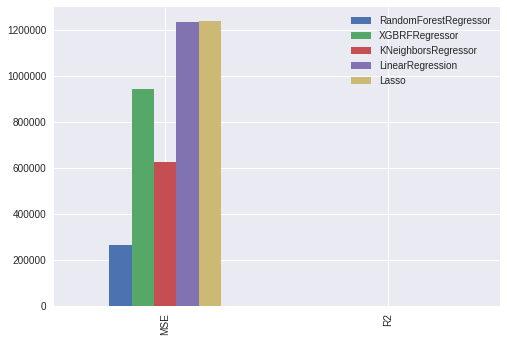

In [107]:
metrics = pd.DataFrame({'RandomForestRegressor':RFR_pre,
                       'XGBRFRegressor':XGBRFR_pre,
                       'KNeighborsRegressor':KNN_pre,
                       'LinearRegression':LR_pre,
                       'Lasso':L_pre})
metrics.plot.bar()